# 1 Classification of Iris Dataset

### David Nicolay 26296918

In [1]:
# imports
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# model result saving
import pickle
import os
from datetime import datetime


# import my utils
import sys
sys.path.append('../')
from src import data_utils, models

# Import the evaluation utilities
from src.active_learning import ModelEvaluator, compare_learning_strategies, ActiveLearningEvaluator
from src.metrics import compute_computational_savings

## Data pre-processing

In [2]:
df = pd.read_csv("../datasets/iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# check for missing values
df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [4]:
df.shape

(150, 6)

### 1. Drop ID column

In [5]:
df = df.drop(columns=["Id"])

### 2. One-hot encode target variable

In [6]:
# one hot encode target variable
df = pd.get_dummies(df, columns=["Species"])
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
0,5.1,3.5,1.4,0.2,True,False,False
1,4.9,3.0,1.4,0.2,True,False,False
2,4.7,3.2,1.3,0.2,True,False,False
3,4.6,3.1,1.5,0.2,True,False,False
4,5.0,3.6,1.4,0.2,True,False,False


### 3. Scale features to [-1, 1]

In [7]:
print(dir(data_utils))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'scale_min_max', 'scale_z_score']


In [8]:
# scale features to [-1, 1]
feature_cols = df.columns[:-3]  # all columns except the last 3 (one-hot encoded target)

df[feature_cols] = data_utils.scale_min_max(df[feature_cols], min_val=-1, max_val=1)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
0,-0.555556,0.250000,-0.864407,-0.916667,True,False,False
1,-0.666667,-0.166667,-0.864407,-0.916667,True,False,False
2,-0.777778,0.000000,-0.898305,-0.916667,True,False,False
3,-0.833333,-0.083333,-0.830508,-0.916667,True,False,False
4,-0.611111,0.333333,-0.864407,-0.916667,True,False,False


### 4. Prepare X and Y matrices and tensors


In [9]:
# Prepare data
X = df[feature_cols].values
y_raw = df[["Species_Iris-setosa", "Species_Iris-versicolor", "Species_Iris-virginica"]].values

# Scale one-hot encoded outputs to [0.1, 0.9] for MSE
# 0 -> 0.1, 1 -> 0.9
y = y_raw * 0.8 + 0.1

# Convert to torch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

In [10]:
# set matplotlib to Times New Roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14


## Modelling

### Passive learning with stochastic gradient descent

#### Find best control parameters

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=12, stratify=y_raw)

# Hyperparameter search function
def train_and_evaluate(hidden_size, learning_rate, weight_decay, momentum, epochs=1000):
    model = models.IrisNet(input_size=4, hidden_size=hidden_size, output_size=3, use_mse=True)
    
    # Use MSE loss for regression-like training with scaled targets [0.1, 0.9]
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
    
    # Training
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train)
        test_outputs = model(X_test)
        
        # Convert outputs back to class predictions
        # Find the class with the highest output value
        train_pred = torch.argmax(train_outputs, dim=1)
        test_pred = torch.argmax(test_outputs, dim=1)
        
        # Convert true labels to class indices for accuracy calculation
        y_train_idx = torch.argmax(y_train, dim=1)
        y_test_idx = torch.argmax(y_test, dim=1)
        
        train_acc = accuracy_score(y_train_idx.numpy(), train_pred.numpy())
        test_acc = accuracy_score(y_test_idx.numpy(), test_pred.numpy())
    
    return model, train_acc, test_acc, losses

# Hyperparameter grid search
hidden_sizes = [64, 128, 256, 512]
learning_rates = [0.01, 0.05, 0.1, 0.5]
weight_decays = [0.0, 0.001, 0.01, 0.1]
momentums = [0.0, 0.5, 0.9, 0.95]  # Added momentum values

best_params = {}
best_test_acc = 0
results = []

print("Searching for best hyperparameters with MSE loss and scaled outputs [0.1, 0.9]...")
for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for wd in weight_decays:
            for momentum in momentums:
                model, train_acc, test_acc, losses = train_and_evaluate(hidden_size, lr, wd, momentum)
                results.append({
                    'hidden_size': hidden_size,
                    'learning_rate': lr,
                    'weight_decay': wd,
                    'momentum': momentum,
                    'train_acc': train_acc,
                    'test_acc': test_acc
                })
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    best_params = {
                        'hidden_size': hidden_size,
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'momentum': momentum,
                        'train_acc': train_acc,
                        'test_acc': test_acc
                    }
                
                print(f"Hidden: {hidden_size}, LR: {lr}, WD: {wd}, Momentum: {momentum}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

print(f"\nBest parameters: {best_params}")
print(f"Total hyperparameter combinations tested: {len(results)}")

Searching for best hyperparameters with MSE loss and scaled outputs [0.1, 0.9]...
Hidden: 64, LR: 0.01, WD: 0.0, Momentum: 0.0, Train Acc: 0.7083, Test Acc: 0.7667
Hidden: 64, LR: 0.01, WD: 0.0, Momentum: 0.5, Train Acc: 0.6750, Test Acc: 0.6667
Hidden: 64, LR: 0.01, WD: 0.0, Momentum: 0.9, Train Acc: 0.8250, Test Acc: 0.8000
Hidden: 64, LR: 0.01, WD: 0.0, Momentum: 0.95, Train Acc: 0.8917, Test Acc: 0.9000
Hidden: 64, LR: 0.01, WD: 0.001, Momentum: 0.0, Train Acc: 0.6667, Test Acc: 0.6667
Hidden: 64, LR: 0.01, WD: 0.001, Momentum: 0.5, Train Acc: 0.6917, Test Acc: 0.6333
Hidden: 64, LR: 0.01, WD: 0.001, Momentum: 0.9, Train Acc: 0.8083, Test Acc: 0.7667
Hidden: 64, LR: 0.01, WD: 0.001, Momentum: 0.95, Train Acc: 0.8667, Test Acc: 0.8667
Hidden: 64, LR: 0.01, WD: 0.01, Momentum: 0.0, Train Acc: 0.6667, Test Acc: 0.6333
Hidden: 64, LR: 0.01, WD: 0.01, Momentum: 0.5, Train Acc: 0.7333, Test Acc: 0.7000
Hidden: 64, LR: 0.01, WD: 0.01, Momentum: 0.9, Train Acc: 0.6667, Test Acc: 0.6667
Hid

In [12]:
# Save best params with pickle
# Create results directory if it doesn't exist
results_dir = "../results/iris"
os.makedirs(results_dir, exist_ok=True)

# Save the best parameters
best_params_filename = os.path.join(results_dir, "best_hyperparameters.pkl")
with open(best_params_filename, 'wb') as f:
    pickle.dump(best_params, f)

# Also save all results from hyperparameter search
hyperparameter_results_filename = os.path.join(results_dir, "hyperparameter_search_results.pkl")
with open(hyperparameter_results_filename, 'wb') as f:
    pickle.dump(results, f)

print(f"Saved best parameters to: {best_params_filename}")
print(f"Saved all hyperparameter search results to: {hyperparameter_results_filename}")
print(f"Best parameters: {best_params}")

Saved best parameters to: ../results/iris/best_hyperparameters.pkl
Saved all hyperparameter search results to: ../results/iris/hyperparameter_search_results.pkl
Best parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.9, 'train_acc': 0.975, 'test_acc': 1.0}


In [11]:


results_dir = "../results/iris"
best_params_filename = os.path.join(results_dir, "best_hyperparameters.pkl")

# Check if the file exists
if os.path.exists(best_params_filename):
    with open(best_params_filename, 'rb') as f:
        loaded_best_params = pickle.load(f)
    
    print("Successfully loaded best parameters:")
    print(f"Best parameters: {loaded_best_params}")
    
    # Verify they match the current best_params
    if 'best_params' in locals():
        print(f"Parameters match current session: {best_params == loaded_best_params}")
    
    # Use loaded parameters (in case we're running this cell independently)
    best_params = loaded_best_params
    
else:
    print(f"Best parameters file not found at: {best_params_filename}")
    print("Make sure to run the hyperparameter search first!")

Successfully loaded best parameters:
Best parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.9, 'train_acc': 0.975, 'test_acc': 1.0}


#### Run 50 trials with best control parameters

In [12]:
# Initialize evaluator
evaluator = ModelEvaluator()

# Run 50 trials with cross-validation
print("Running 50 trials with best parameters and 5-fold cross-validation...")
passive_results = evaluator.evaluate_passive_learning(
    X=X_tensor,
    y=y_tensor,
    best_params=best_params,
    n_trials=50,
    use_cv=True,  # Enable 5-fold cross-validation
    cv_folds=5,
    epochs=1000,
    random_state=12
)

# Print comprehensive report
print("\n")
evaluator.print_report()

Running 50 trials with best parameters and 5-fold cross-validation...
Starting 50 trial evaluation...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.9, 'train_acc': 0.975, 'test_acc': 1.0}
Cross-validation: Yes (5 folds)
Trial 1/50... Test Acc: 1.0000, Time: 2.11s
Trial 2/50... Test Acc: 1.0000, Time: 1.18s
Trial 3/50... Test Acc: 0.9667, Time: 1.15s
Trial 4/50... Test Acc: 0.9000, Time: 1.18s
Trial 5/50... Test Acc: 1.0000, Time: 1.19s
Trial 6/50... Test Acc: 0.9667, Time: 1.20s
Trial 7/50... Test Acc: 1.0000, Time: 1.17s
Trial 8/50... Test Acc: 1.0000, Time: 1.17s
Trial 9/50... Test Acc: 0.9667, Time: 1.19s
Trial 10/50... Test Acc: 0.9667, Time: 1.23s
Trial 11/50... Test Acc: 0.9333, Time: 1.19s
Trial 12/50... Test Acc: 1.0000, Time: 1.17s
Trial 13/50... Test Acc: 0.9667, Time: 1.18s
Trial 14/50... Test Acc: 0.9333, Time: 1.17s
Trial 15/50... Test Acc: 1.0000, Time: 1.21s
Trial 16/50... 

KeyboardInterrupt: 

In [15]:
# Save evaluator and passive_results to ../results/iris/


# Create results directory if it doesn't exist
results_dir = "../results/iris"
os.makedirs(results_dir, exist_ok=True)

# Save the evaluator object with all its metrics
evaluator_filename = os.path.join(results_dir, "passive_learning_evaluator.pkl")
with open(evaluator_filename, 'wb') as f:
    pickle.dump(evaluator, f)

# Save the passive_results dictionary
results_filename = os.path.join(results_dir, "passive_learning_results.pkl")
with open(results_filename, 'wb') as f:
    pickle.dump(passive_results, f)

# Also save as JSON for easier inspection (excluding non-serializable objects)
import json

# Create a JSON-serializable version of passive_results
json_results = {}
for key, value in passive_results.items():
    if isinstance(value, (int, float, str, bool, list, dict)):
        json_results[key] = value
    elif hasattr(value, 'tolist'):  # numpy arrays
        json_results[key] = value.tolist() if hasattr(value, 'tolist') else str(value)
    else:
        json_results[key] = str(value)

# Add metadata
json_results['saved_at'] = datetime.now().isoformat()
json_results['dataset'] = 'iris'
json_results['method'] = 'passive_learning_sgd'

json_filename = os.path.join(results_dir, "passive_learning_results.json")
with open(json_filename, 'w') as f:
    json.dump(json_results, f, indent=2)

print(f"Saved evaluator to: {evaluator_filename}")
print(f"Saved passive_results to: {results_filename}")
print(f"Saved JSON results to: {json_filename}")

# Save detailed metrics from the evaluator's tracker
metrics_data = {
    'train_accuracies': evaluator.metrics_tracker.train_accuracies,
    'test_accuracies': evaluator.metrics_tracker.test_accuracies,
    'val_accuracies': evaluator.metrics_tracker.val_accuracies,
    'losses_per_trial': evaluator.metrics_tracker.losses_per_trial,
    'epochs_to_converge': evaluator.metrics_tracker.epochs_to_converge,
    'pattern_presentations': evaluator.metrics_tracker.pattern_presentations,
    'computation_times': evaluator.metrics_tracker.computation_times,
    'saved_at': datetime.now().isoformat(),
    'n_trials': 50,
    'method': 'passive_learning_sgd'
}

metrics_filename = os.path.join(results_dir, "passive_learning_detailed_metrics.pkl")
with open(metrics_filename, 'wb') as f:
    pickle.dump(metrics_data, f)

print(f"Saved detailed metrics to: {metrics_filename}")

# Create a summary text file for easy reference
summary_filename = os.path.join(results_dir, "passive_learning_summary.txt")
with open(summary_filename, 'w') as f:
    f.write("PASSIVE LEARNING RESULTS SUMMARY\n")
    f.write("=" * 50 + "\n")
    f.write(f"Saved at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset: Iris\n")
    f.write(f"Method: Passive Learning with SGD\n")
    f.write(f"Number of trials: 50\n")
    f.write(f"Cross-validation: 5-fold\n\n")
    
    f.write("PERFORMANCE METRICS:\n")
    f.write("-" * 20 + "\n")
    f.write(f"Training Accuracy: {passive_results['train_acc_mean']:.4f} ± {passive_results['train_acc_std']:.4f}\n")
    f.write(f"Test Accuracy: {passive_results['test_acc_mean']:.4f} ± {passive_results['test_acc_std']:.4f}\n")
    f.write(f"Validation Accuracy: {passive_results['val_acc_mean']:.4f} ± {passive_results['val_acc_std']:.4f}\n")
    f.write(f"Best Test Accuracy: {passive_results['best_test_acc']:.4f}\n")
    f.write(f"Convergence Rate: {passive_results['convergence_rate']:.1%}\n")
    f.write(f"Avg Pattern Presentations: {passive_results['avg_pattern_presentations']:.1f}\n")
    
    f.write(f"\nBEST PARAMETERS:\n")
    f.write("-" * 15 + "\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")

print(f"Saved summary to: {summary_filename}")
print(f"\nAll files saved in: {results_dir}")

Saved evaluator to: ../results/iris/passive_learning_evaluator.pkl
Saved passive_results to: ../results/iris/passive_learning_results.pkl
Saved JSON results to: ../results/iris/passive_learning_results.json
Saved detailed metrics to: ../results/iris/passive_learning_detailed_metrics.pkl
Saved summary to: ../results/iris/passive_learning_summary.txt

All files saved in: ../results/iris


In [ ]:
# UNCOMMENT TO LOAD THE SAVED EVALUATOR AND RESULTS
# import pickle

# # Load the evaluator
# with open('../results/iris/passive_learning_evaluator.pkl', 'rb') as f:
#     loaded_evaluator = pickle.load(f)

# # Load the results
# with open('../results/iris/passive_learning_results.pkl', 'rb') as f:
#     loaded_passive_results = pickle.load(f)

In [16]:

passive_learning_results = passive_results.copy()

# Extract key metrics for detailed analysis
print(f"\nDETAILED METRICS SUMMARY")
print("=" * 60)
print(f"Training Accuracy: {passive_results['train_acc_mean']:.4f} ± {passive_results['train_acc_std']:.4f}")
print(f"Test Accuracy: {passive_results['test_acc_mean']:.4f} ± {passive_results['test_acc_std']:.4f}")
print(f"Validation Accuracy: {passive_results['val_acc_mean']:.4f} ± {passive_results['val_acc_std']:.4f}")

print(f"\n95% Confidence Intervals:")
print(f"  Train: [{passive_results['train_acc_95ci'][0]:.4f}, {passive_results['train_acc_95ci'][1]:.4f}]")
print(f"  Test:  [{passive_results['test_acc_95ci'][0]:.4f}, {passive_results['test_acc_95ci'][1]:.4f}]")

print(f"\nBest Model Performance:")
print(f"  Best Test Accuracy: {passive_results['best_test_acc']:.4f}")
print(f"  Pattern Presentations: {passive_results['best_test_patterns']}")
print(f"  Generalization Factor: {passive_results['generalization_factor']:.4f}")

print(f"\nEfficiency Metrics:")
print(f"  Avg Pattern Presentations: {passive_results['avg_pattern_presentations']:.1f} ± {passive_results['std_pattern_presentations']:.1f}")
print(f"  Convergence Rate: {passive_results['convergence_rate']:.1%}")
if passive_results['avg_epochs_to_converge'] is not None:
    print(f"  Avg Epochs to Converge: {passive_results['avg_epochs_to_converge']:.1f} ± {passive_results['std_epochs_to_converge']:.1f}")


DETAILED METRICS SUMMARY
Training Accuracy: 0.9898 ± 0.0060
Test Accuracy: 0.9693 ± 0.0304
Validation Accuracy: 0.9628 ± 0.0115

95% Confidence Intervals:
  Train: [0.9881, 0.9915]
  Test:  [0.9606, 0.9781]

Best Model Performance:
  Best Test Accuracy: 1.0000
  Pattern Presentations: 3720
  Generalization Factor: 1.0169

Efficiency Metrics:
  Avg Pattern Presentations: 3033.6 ± 244.8
  Convergence Rate: 78.0%
  Avg Epochs to Converge: 25.5 ± 1.9


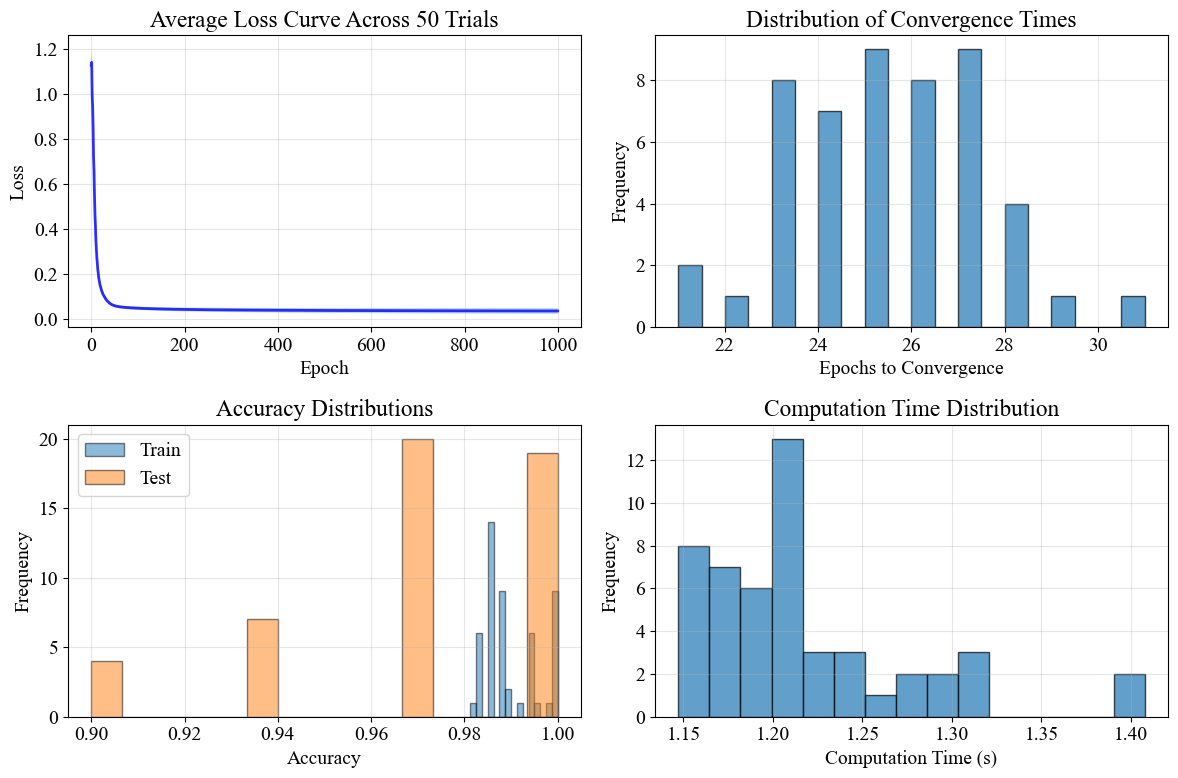


COMPUTATIONAL EFFICIENCY
Average computation time per trial: 1.216 ± 0.058 seconds
Total evaluation time: 60.8 seconds (1.0 minutes)


In [17]:
# Analyze loss convergence patterns across trials


# Plot average loss curves
plt.figure(figsize=(12, 8))

# Get all losses from trials
all_losses = evaluator.metrics_tracker.losses_per_trial

# Calculate average loss curve (pad shorter sequences with last value)
max_epochs = max(len(losses) for losses in all_losses)
padded_losses = []
for losses in all_losses:
    padded = losses + [losses[-1]] * (max_epochs - len(losses))
    padded_losses.append(padded)

avg_losses = np.mean(padded_losses, axis=0)
std_losses = np.std(padded_losses, axis=0)

plt.subplot(2, 2, 1)
epochs = range(len(avg_losses))
plt.plot(epochs, avg_losses, 'b-', alpha=0.8, linewidth=2)
plt.fill_between(epochs, avg_losses - std_losses, avg_losses + std_losses, alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Curve Across 50 Trials')
plt.grid(True, alpha=0.3)

# Plot convergence distribution
plt.subplot(2, 2, 2)
convergence_epochs = evaluator.metrics_tracker.epochs_to_converge
plt.hist(convergence_epochs, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Epochs to Convergence')
plt.ylabel('Frequency')
plt.title('Distribution of Convergence Times')
plt.grid(True, alpha=0.3)

# Plot accuracy distributions
plt.subplot(2, 2, 3)
train_accs = evaluator.metrics_tracker.train_accuracies
test_accs = evaluator.metrics_tracker.test_accuracies
plt.hist(train_accs, alpha=0.5, label='Train', bins=15, edgecolor='black')
plt.hist(test_accs, alpha=0.5, label='Test', bins=15, edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Distributions')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot computation time distribution
plt.subplot(2, 2, 4)
comp_times = evaluator.metrics_tracker.computation_times
plt.hist(comp_times, bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('Computation Time (s)')
plt.ylabel('Frequency')
plt.title('Computation Time Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCOMPUTATIONAL EFFICIENCY")
print(f"Average computation time per trial: {np.mean(comp_times):.3f} ± {np.std(comp_times):.3f} seconds")
print(f"Total evaluation time: {np.sum(comp_times):.1f} seconds ({np.sum(comp_times)/60:.1f} minutes)")

In [18]:
# Create a comprehensive results dictionary for later use
passive_learning_summary = {
    'strategy': 'Passive Learning (SGD)',
    'parameters': best_params,
    'results': passive_results,
    'raw_data': {
        'train_accuracies': evaluator.metrics_tracker.train_accuracies,
        'test_accuracies': evaluator.metrics_tracker.test_accuracies,
        'val_accuracies': evaluator.metrics_tracker.val_accuracies,
        'losses_per_trial': evaluator.metrics_tracker.losses_per_trial,
        'epochs_to_converge': evaluator.metrics_tracker.epochs_to_converge,
        'pattern_presentations': evaluator.metrics_tracker.pattern_presentations,
        'computation_times': evaluator.metrics_tracker.computation_times
    }
}

# Save key results for comparison
print("Passive learning evaluation completed!")
print(f"Results saved for comparison with active learning methods")
print(f"Best test accuracy achieved: {passive_results['best_test_acc']:.4f}")
print(f"Average test accuracy: {passive_results['test_acc_mean']:.4f} ± {passive_results['test_acc_std']:.4f}")
print(f"Average training efficiency: {passive_results['avg_pattern_presentations']:.0f} pattern presentations")

Passive learning evaluation completed!
Results saved for comparison with active learning methods
Best test accuracy achieved: 1.0000
Average test accuracy: 0.9693 ± 0.0304
Average training efficiency: 3034 pattern presentations


#### Evaluation

In [19]:
# 1. Print metrics
passive_learning_results

{'train_acc_mean': np.float64(0.9898333333333333),
 'train_acc_std': np.float64(0.005960518247415915),
 'test_acc_mean': np.float64(0.9693333333333334),
 'test_acc_std': np.float64(0.030433899228035532),
 'num_trials': 50,
 'val_acc_mean': np.float64(0.9628333333333334),
 'val_acc_std': np.float64(0.011451588924201254),
 'train_f1_mean': np.float64(0.9898328245828245),
 'train_f1_std': np.float64(0.005960525390591623),
 'train_precision_mean': np.float64(0.9898912512218964),
 'train_precision_std': np.float64(0.005965730968889094),
 'train_recall_mean': np.float64(0.9898333333333333),
 'train_recall_std': np.float64(0.005960518247415915),
 'train_mcc_mean': np.float64(0.9847794464796417),
 'train_mcc_std': np.float64(0.008943240347882948),
 'test_f1_mean': np.float64(0.9691849710043275),
 'test_f1_std': np.float64(0.030641065085753927),
 'test_precision_mean': np.float64(0.9720372960372959),
 'test_precision_std': np.float64(0.028095739152635798),
 'test_recall_mean': np.float64(0.9693

In [21]:
# 2. Print epochs to converge
evaluator.metrics_tracker.epochs_to_converge

[31,
 29,
 27,
 27,
 25,
 22,
 24,
 23,
 27,
 25,
 27,
 25,
 25,
 24,
 24,
 21,
 23,
 23,
 24,
 24,
 27,
 24,
 23,
 21,
 27,
 26,
 26,
 27,
 25,
 27,
 26,
 27,
 26,
 23,
 28,
 25,
 23,
 24,
 26,
 28,
 28,
 25,
 23,
 25,
 28,
 26,
 26,
 25,
 23,
 26]

[np.float64(0.975),
 np.float64(0.975),
 np.float64(0.9416666666666668),
 np.float64(0.95),
 np.float64(0.975),
 np.float64(0.975),
 np.float64(0.9666666666666666),
 np.float64(0.9583333333333333),
 np.float64(0.9583333333333334),
 np.float64(0.9583333333333334),
 np.float64(0.975),
 np.float64(0.9416666666666668),
 np.float64(0.9666666666666666),
 np.float64(0.9833333333333334),
 np.float64(0.9583333333333334),
 np.float64(0.9583333333333334),
 np.float64(0.9416666666666668),
 np.float64(0.9583333333333334),
 np.float64(0.9583333333333334),
 np.float64(0.9416666666666668),
 np.float64(0.9583333333333334),
 np.float64(0.9666666666666668),
 np.float64(0.975),
 np.float64(0.9666666666666666),
 np.float64(0.9666666666666668),
 np.float64(0.9583333333333334),
 np.float64(0.975),
 np.float64(0.9916666666666668),
 np.float64(0.9666666666666668),
 np.float64(0.9583333333333334),
 np.float64(0.9666666666666668),
 np.float64(0.9666666666666666),
 np.float64(0.9583333333333334),
 np.float64(0.96

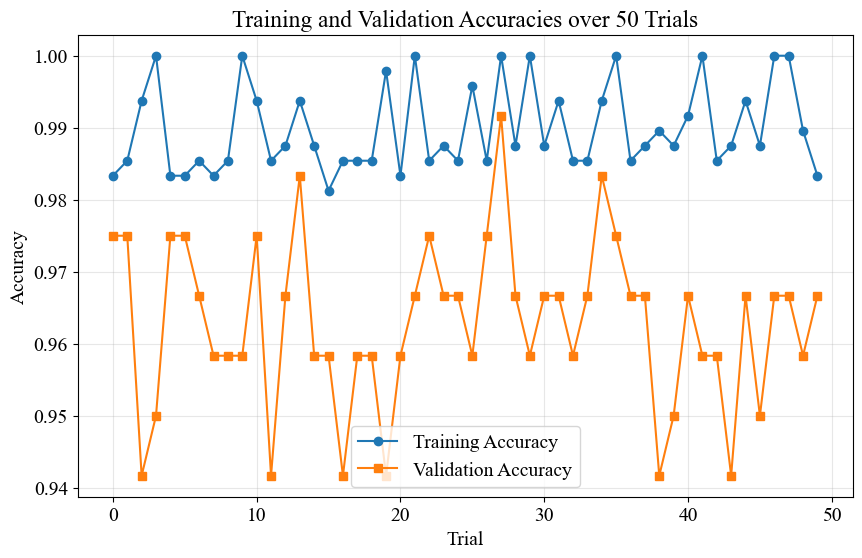

In [ ]:
# 3. Plot Training & Validation Accuracies over epochs
plt.figure(figsize=(10, 6))
plt.plot(, label='Training Accuracy', marker='o')

### SASLA Active Learning Implementation



#### Key SASLA Components:

1. **Exact Sensitivity Calculation**: Using derivatives (Equation 4): 
   `S_oz(k,i) = (1 - o_k) * o_k * Σ_j [w_kj * (1 - y_j) * y_j * v_ji]`

2. **Pattern Informativeness**: Mathematical definition (Equations 1-2) with sum-norm followed by max-norm

3. **Selection Strategy**: Select patterns with informativeness > `(1-α) * average_informativeness`

4. **Selection Constant α = 0.9**: Conservative approach to retain high-quality patterns

5. **Selection Frequency**: Every epoch (configurable interval)

In [22]:
# Output Sensitivity Active Learning Evaluation (CORRECTED SASLA)
from src.active_learning import ActiveLearningEvaluator

print("=== CORRECTED SASLA ACTIVE LEARNING EVALUATION ===")
print("Implementing true SASLA (Sensitivity Analysis for Selective Learning Algorithm)")
print("Using exact mathematical formulation from the paper:")
print("- Exact derivative-based sensitivity calculation (Equation 4)")
print("- Pattern informativeness with sum-norm and max-norm (Equations 1-2)")
print("- Selection threshold: (1-α) * average_informativeness")
print("- α = 0.9 (conservative selection constant)")
print()

# Create evaluator for output sensitivity
os_evaluator = ActiveLearningEvaluator(convergence_threshold=0.95)

# Run evaluation with correct SASLA parameters
print("Running Output Sensitivity (SASLA) evaluation...")
print("This may take some time due to derivative calculations...")
os_results = os_evaluator.evaluate_active_learning(
    X_tensor, y_tensor,
    best_params,
    strategy='output_sensitivity',
    n_trials=50,
    use_cv=False,
    cv_folds=5,
    epochs=1000,
    random_state=12,
    # SASLA-specific parameters (from the paper)
    alpha=0.9,                      # Selection constant (conservative approach)
    selection_interval=1            # Apply selection every epoch
)

print("Output Sensitivity (SASLA) evaluation completed!")
print()

# Print detailed report
os_evaluator.print_report()

# Store results for comparison
output_sensitivity_results = os_results.copy()

print(f"\nTraining Set Reduction Summary:")
print("="*50)
for epoch, stats in output_sensitivity_results.get('training_set_reductions', {}).items():
    print(f"At {epoch}: {stats['mean']:.2f}% ± {stats['std']:.2f}% reduction")

=== CORRECTED SASLA ACTIVE LEARNING EVALUATION ===
Implementing true SASLA (Sensitivity Analysis for Selective Learning Algorithm)
Using exact mathematical formulation from the paper:
- Exact derivative-based sensitivity calculation (Equation 4)
- Pattern informativeness with sum-norm and max-norm (Equations 1-2)
- Selection threshold: (1-α) * average_informativeness
- α = 0.9 (conservative selection constant)

Running Output Sensitivity (SASLA) evaluation...
This may take some time due to derivative calculations...
Starting 50 trial evaluation for output_sensitivity active learning...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.9, 'train_acc': 0.975, 'test_acc': 1.0}
Cross-validation: No (5 folds)
Trial 1/50
Trial 2/50
Trial 3/50
Trial 4/50
Trial 5/50
Trial 6/50
Trial 7/50
Trial 8/50
Trial 9/50
Trial 10/50
Trial 11/50
Trial 12/50
Trial 13/50
Trial 14/50
Trial 15/50
Trial 16/50
Trial 17/50
Trial 18/50
Trial 19/50
Trial 20/50
Trial 21/50
Tria

In [13]:
# run single trial of output sensitivity approach

# Create evaluator for output sensitivity
os_evaluator_single = ActiveLearningEvaluator(convergence_threshold=0.95)

# Run evaluation with correct SASLA parameters

os_results_single = os_evaluator_single.evaluate_active_learning(
    X_tensor, y_tensor,
    best_params,
    strategy='output_sensitivity',
    n_trials=1,
    use_cv=False,
    cv_folds=5,
    epochs=1000,
    random_state=12,
    # SASLA-specific parameters (from the paper)
    alpha=0.9,                      # Selection constant (conservative approach)
    selection_interval=1            # Apply selection every epoch
)

Starting 1 trial evaluation for output_sensitivity active learning...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.9, 'train_acc': 0.975, 'test_acc': 1.0}
Cross-validation: No (5 folds)
Trial 1/1


/home/davidnicolay/Documents/ml441/ml441_assignments/assign3/notebooks/../src/metrics.py:156: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  scale=stats.sem(train_acc_array))
/home/davidnicolay/Documents/ml441/ml441_assignments/assign3/notebooks/../src/metrics.py:159: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  scale=stats.sem(test_acc_array))


#### Evaluation

In [24]:
# 1. Print metrics
output_sensitivity_results

{'train_acc_mean': np.float64(0.9986531986531986),
 'train_acc_std': np.float64(0.006632227475956977),
 'test_acc_mean': np.float64(0.9266666666666667),
 'test_acc_std': np.float64(0.04898979485566355),
 'num_trials': 50,
 'train_acc_95ci': (np.float64(0.9967492043528141),
  np.float64(1.000557192953583)),
 'test_acc_95ci': (np.float64(0.9126025697218121),
  np.float64(0.9407307636115214)),
 'best_test_acc': np.float64(1.0),
 'best_test_patterns': 3840,
 'best_test_epochs': 32,
 'generalization_factor': np.float64(1.0),
 'avg_pattern_presentations': np.float64(4183.2),
 'std_pattern_presentations': np.float64(1008.8596334475873),
 'avg_computation_time': np.float64(122.13795886039733),
 'std_computation_time': np.float64(19.935288342908365),
 'convergence_rate': 0.34,
 'avg_epochs_to_converge': np.float64(33.705882352941174),
 'std_epochs_to_converge': np.float64(9.073326816310043),
 'learning_type': 'active_output_sensitivity',
 'best_params': {'hidden_size': 64,
  'learning_rate': 0.

In [37]:
# 2. Print epochs to converge
os_evaluator.metrics_tracker.epochs_to_converge

[32,
 47,
 48,
 40,
 38,
 22,
 40,
 44,
 41,
 38,
 19,
 17,
 34,
 35,
 42,
 15,
 39,
 18,
 35,
 43,
 36,
 42,
 43,
 26,
 40,
 34,
 42,
 41,
 36,
 40,
 17,
 38,
 26,
 36,
 41,
 31,
 45,
 37,
 42,
 30,
 37,
 35,
 27,
 40,
 38,
 37,
 39,
 34,
 29,
 17]

In [35]:
# add size 120 for epoch 0 to list at start
os_evaluator_single.training_set_sizes_by_epoch = {0: [120], **os_evaluator_single.training_set_sizes_by_epoch}

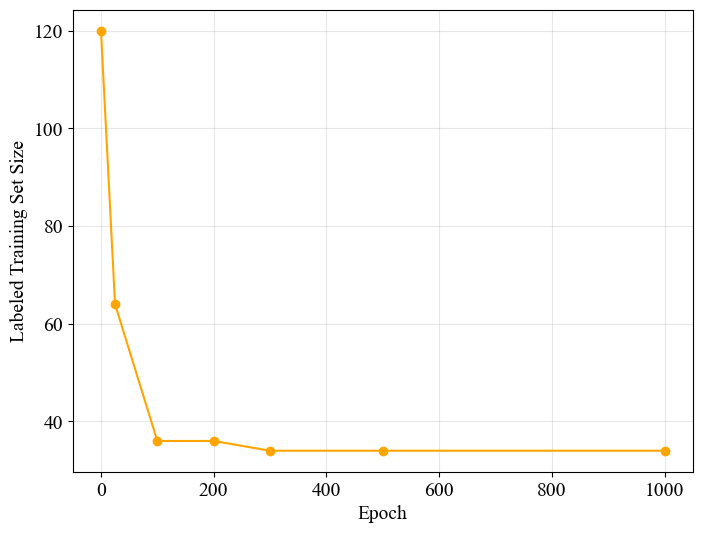

In [38]:
# 3. Plot training set size reduction over epochs using results from single trial


# plot it
plt.figure(figsize=(8, 6))
epochs = list(os_evaluator_single.training_set_sizes_by_epoch.keys())
sizes = list(os_evaluator_single.training_set_sizes_by_epoch.values())
plt.plot(epochs, sizes, marker='o', color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Labeled Training Set Size')
plt.grid(True, alpha=0.3)
plt.savefig('../results/iris/os_training_set_size_reduction.pdf', dpi=300, bbox_inches='tight')
plt.show()


### Active learning with uncertainty sampling



In [11]:
# Uncertainty sampling with enhanced training set size tracking
print("=" * 80)
print("RUNNING UNCERTAINTY SAMPLING WITH ENHANCED TRACKING")
print("=" * 80)
print()

# Create new evaluator for enhanced uncertainty sampling
us_evaluator_enhanced = ActiveLearningEvaluator(convergence_threshold=0.95)

print("Running Enhanced Uncertainty Sampling Active Learning evaluation...")
us_results_enhanced = us_evaluator_enhanced.evaluate_active_learning(
    X=X_tensor,
    y=y_tensor,
    best_params=best_params,
    strategy='uncertainty_sampling',
    n_trials=50,
    use_cv=True,
    cv_folds=5,
    epochs=1000,
    random_state=12,
    uncertainty_method='entropy'
)

print("\nEvaluation completed!")

RUNNING UNCERTAINTY SAMPLING WITH ENHANCED TRACKING

Running Enhanced Uncertainty Sampling Active Learning evaluation...
Starting 50 trial evaluation for uncertainty_sampling active learning...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.9, 'train_acc': 0.975, 'test_acc': 1.0}
Cross-validation: Yes (5 folds)
Trial 1/50
Trial 2/50
Trial 2/50
Trial 3/50
Trial 3/50
Trial 4/50
Trial 4/50
Trial 5/50
Trial 5/50
Trial 6/50
Trial 6/50
Trial 7/50
Trial 7/50
Trial 8/50
Trial 8/50
Trial 9/50
Trial 9/50
Trial 10/50
Trial 10/50
Trial 11/50
Trial 11/50
Trial 12/50
Trial 12/50
Trial 13/50
Trial 13/50
Trial 14/50
Trial 14/50
Trial 15/50
Trial 15/50
Trial 16/50
Trial 16/50
Trial 17/50
Trial 17/50
Trial 18/50
Trial 18/50
Trial 19/50
Trial 19/50
Trial 20/50
Trial 20/50
Trial 21/50
Trial 21/50
Trial 22/50
Trial 22/50
Trial 23/50
Trial 23/50
Trial 24/50
Trial 24/50
Trial 25/50
Trial 25/50
Trial 26/50
Trial 26/50
Trial 27/50
Trial 27/50
Trial 28/50
Trial 28/50
Tr

In [12]:
# Print detailed results with training set size tracking
print("\n" + "=" * 80)
print("ENHANCED UNCERTAINTY SAMPLING RESULTS")
print("=" * 80)

us_evaluator_enhanced.print_report()

print(f"\nTRAINING SET SIZE ANALYSIS")
print("=" * 50)

# Final training set sizes
if 'final_training_set_size_mean' in us_results_enhanced:
    print(f"Original Training Set Size: {us_results_enhanced['original_training_set_size_mean']:.0f}")
    print(f"Final Training Set Size: {us_results_enhanced['final_training_set_size_mean']:.1f} ± {us_results_enhanced['final_training_set_size_std']:.1f}")
    print(f"Training Set Reduction: {us_results_enhanced['training_set_reduction_mean']:.1f}% ± {us_results_enhanced['training_set_reduction_std']:.1f}%")

# Training set sizes at specific epochs
if 'training_set_sizes_by_epoch' in us_results_enhanced:
    print(f"\nTraining Set Sizes at Specific Epochs:")
    print("-" * 40)
    for epoch_key, stats in us_results_enhanced['training_set_sizes_by_epoch'].items():
        epoch = epoch_key.replace('size_at_', '').replace('_epochs', '')
        print(f"  Epoch {epoch:>4}: {stats['mean']:>6.1f} ± {stats['std']:>5.1f} samples (range: {stats['min']:.0f}-{stats['max']:.0f})")

# Store results for comparison
uncertainty_sampling_results_enhanced = us_results_enhanced.copy()


ENHANCED UNCERTAINTY SAMPLING RESULTS
COMPREHENSIVE EVALUATION REPORT

ACCURACY METRICS (n=50 trials)
--------------------------------------------------
Train Accuracy: 0.9692 ± 0.0105
Test Accuracy:  0.9613 ± 0.0322
Val Accuracy:   0.9613 ± 0.0105

95% CONFIDENCE INTERVALS
--------------------------------------------------
Train Accuracy: [0.9662, 0.9722]
Test Accuracy:  [0.9521, 0.9706]

BEST GENERALIZATION
--------------------------------------------------
Best Test Accuracy: 1.0000
Pattern Presentations: 0
Epochs to Best: 0
Generalization Factor: 1.0453

EFFICIENCY METRICS
--------------------------------------------------
Avg Pattern Presentations: 801.6 ± 668.8
Avg Computation Time: 1.955s ± 0.165s

CONVERGENCE ANALYSIS
--------------------------------------------------
Convergence Rate (≥95.0%): 72.0%
Avg Epochs to Converge: 6.9 ± 5.5

TRAINING SET SIZE ANALYSIS
Original Training Set Size: 120
Final Training Set Size: 112.0 ± 0.0
Training Set Reduction: 6.7% ± 0.0%

Training Se

#### Evaluation

In [ ]:
# TODO

### Active learning with uncertainty sampling Ensemble

In [13]:
# Ensemble Uncertainty Sampling Active Learning Evaluation
print("=" * 80)
print("RUNNING ENSEMBLE UNCERTAINTY SAMPLING ACTIVE LEARNING")
print("=" * 80)
print()
print("Ensemble approach:")
print("1. Train multiple NNs with different random initializations")
print("2. At inference, average predictions across ensemble members")
print("3. Uncertainty = variance across ensemble predictions")
print("4. Select samples with highest prediction variance for labeling")
print("5. Using 3 models in ensemble for computational efficiency")
print()

# Create evaluator for ensemble uncertainty sampling
ensemble_evaluator = ActiveLearningEvaluator(convergence_threshold=0.95)

print("Running Ensemble Uncertainty Sampling evaluation...")
print("Using 3 models in ensemble (kept small for efficiency)...")
ensemble_results = ensemble_evaluator.evaluate_active_learning(
    X=X_tensor,
    y=y_tensor,
    best_params=best_params,
    strategy='ensemble_uncertainty',
    n_trials=50,
    use_cv=False,
    cv_folds=5,
    epochs=1000,
    random_state=12,
    n_ensemble=3  # Keep ensemble small for computational efficiency
)

print("\nEnsemble Uncertainty Sampling evaluation completed!")

RUNNING ENSEMBLE UNCERTAINTY SAMPLING ACTIVE LEARNING

Ensemble approach:
1. Train multiple NNs with different random initializations
2. At inference, average predictions across ensemble members
3. Uncertainty = variance across ensemble predictions
4. Select samples with highest prediction variance for labeling
5. Using 3 models in ensemble for computational efficiency

Running Ensemble Uncertainty Sampling evaluation...
Using 3 models in ensemble (kept small for efficiency)...
Starting 50 trial evaluation for ensemble_uncertainty active learning...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.9, 'train_acc': 0.975, 'test_acc': 1.0}
Cross-validation: No (5 folds)
Trial 1/50
Trial 2/50
Trial 2/50
Trial 3/50
Trial 3/50
Trial 4/50
Trial 4/50
Trial 5/50
Trial 5/50
Trial 6/50
Trial 6/50
Trial 7/50
Trial 7/50
Trial 8/50
Trial 8/50
Trial 9/50
Trial 9/50
Trial 10/50
Trial 10/50
Trial 11/50
Trial 11/50
Trial 12/50
Trial 12/50
Trial 13/50
Trial 13/50
T

In [14]:
# Print detailed results with training set size tracking
print("\n" + "=" * 80)
print("ENSEMBLE UNCERTAINTY SAMPLING RESULTS")
print("=" * 80)

ensemble_evaluator.print_report()

print(f"\nTRAINING SET SIZE ANALYSIS")
print("=" * 50)

# Final training set sizes
if 'final_training_set_size_mean' in ensemble_results:
    print(f"Original Training Set Size: {ensemble_results['original_training_set_size_mean']:.0f}")
    print(f"Final Training Set Size: {ensemble_results['final_training_set_size_mean']:.1f} ± {ensemble_results['final_training_set_size_std']:.1f}")
    print(f"Training Set Reduction: {ensemble_results['training_set_reduction_mean']:.1f}% ± {ensemble_results['training_set_reduction_std']:.1f}%")

# Training set sizes at specific epochs
if 'training_set_sizes_by_epoch' in ensemble_results:
    print(f"\nTraining Set Sizes at Specific Epochs:")
    print("-" * 40)
    for epoch_key, stats in ensemble_results['training_set_sizes_by_epoch'].items():
        epoch = epoch_key.replace('size_at_', '').replace('_epochs', '')
        print(f"  Epoch {epoch:>4}: {stats['mean']:>6.1f} ± {stats['std']:>5.1f} samples (range: {stats['min']:.0f}-{stats['max']:.0f})")

print(f"\nENSEMBLE SPECIFIC METRICS")
print("=" * 30)
print(f"Ensemble Size: 3 models")
print(f"Uncertainty Measure: Variance across ensemble predictions")
print(f"Selection Strategy: Highest prediction variance")

# Store results for comparison
ensemble_uncertainty_results = ensemble_results.copy()


ENSEMBLE UNCERTAINTY SAMPLING RESULTS
COMPREHENSIVE EVALUATION REPORT

ACCURACY METRICS (n=50 trials)
--------------------------------------------------
Train Accuracy: 0.9780 ± 0.0084
Test Accuracy:  0.9660 ± 0.0302

95% CONFIDENCE INTERVALS
--------------------------------------------------
Train Accuracy: [0.9756, 0.9805]
Test Accuracy:  [0.9573, 0.9747]

BEST GENERALIZATION
--------------------------------------------------
Best Test Accuracy: 1.0000
Pattern Presentations: 1920
Epochs to Best: 16
Generalization Factor: 1.0275

EFFICIENCY METRICS
--------------------------------------------------
Avg Pattern Presentations: 1485.6 ± 711.1
Avg Computation Time: 0.850s ± 0.027s

CONVERGENCE ANALYSIS
--------------------------------------------------
Convergence Rate (≥95.0%): 74.0%
Avg Epochs to Converge: 12.6 ± 5.8

TRAINING SET SIZE ANALYSIS
Original Training Set Size: 120
Final Training Set Size: 112.0 ± 0.0
Training Set Reduction: 6.7% ± 0.0%

Training Set Sizes at Specific Epochs

#### Evaluation

In [16]:
# Save ensemble results for comparison and persistence
results_dir = "../results/iris"
os.makedirs(results_dir, exist_ok=True)

# Save ensemble evaluator and results
ensemble_evaluator_filename = os.path.join(results_dir, "ensemble_uncertainty_evaluator.pkl")
with open(ensemble_evaluator_filename, 'wb') as f:
    pickle.dump(ensemble_evaluator, f)

ensemble_results_filename = os.path.join(results_dir, "ensemble_uncertainty_results.pkl")
with open(ensemble_results_filename, 'wb') as f:
    pickle.dump(ensemble_results, f)

# Create summary for ensemble approach
ensemble_summary_filename = os.path.join(results_dir, "ensemble_uncertainty_summary.txt")
with open(ensemble_summary_filename, 'w') as f:
    f.write("ENSEMBLE UNCERTAINTY SAMPLING RESULTS SUMMARY\n")
    f.write("=" * 60 + "\n")
    f.write(f"Saved at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset: Iris\n")
    f.write(f"Method: Ensemble Uncertainty Sampling Active Learning\n")
    f.write(f"Number of trials: 50\n")
    f.write(f"Cross-validation: 5-fold\n")
    f.write(f"Ensemble size: 3 models\n\n")
    
    f.write("PERFORMANCE METRICS:\n")
    f.write("-" * 20 + "\n")
    f.write(f"Training Accuracy: {ensemble_results['train_acc_mean']:.4f} ± {ensemble_results['train_acc_std']:.4f}\n")
    f.write(f"Test Accuracy: {ensemble_results['test_acc_mean']:.4f} ± {ensemble_results['test_acc_std']:.4f}\n")
    # f.write(f"Validation Accuracy: {ensemble_results['val_acc_mean']:.4f} ± {ensemble_results['val_acc_std']:.4f}\n")
    f.write(f"Best Test Accuracy: {ensemble_results['best_test_acc']:.4f}\n")
    f.write(f"Convergence Rate: {ensemble_results['convergence_rate']:.1%}\n")
    f.write(f"Avg Pattern Presentations: {ensemble_results['avg_pattern_presentations']:.1f}\n")
    
    if 'final_training_set_size_mean' in ensemble_results:
        f.write(f"\nTRAINING SET EFFICIENCY:\n")
        f.write("-" * 25 + "\n")
        f.write(f"Original Training Set Size: {ensemble_results['original_training_set_size_mean']:.0f}\n")
        f.write(f"Final Training Set Size: {ensemble_results['final_training_set_size_mean']:.1f} ± {ensemble_results['final_training_set_size_std']:.1f}\n")
        f.write(f"Training Set Reduction: {ensemble_results['training_set_reduction_mean']:.1f}% ± {ensemble_results['training_set_reduction_std']:.1f}%\n")

print(f"Saved ensemble evaluator to: {ensemble_evaluator_filename}")
print(f"Saved ensemble results to: {ensemble_results_filename}")
print(f"Saved ensemble summary to: {ensemble_summary_filename}")

print(f"\nEnsemble Active Learning Summary:")
print(f"Test Accuracy: {ensemble_results['test_acc_mean']:.4f} ± {ensemble_results['test_acc_std']:.4f}")
print(f"Training Efficiency: {ensemble_results['training_set_reduction_mean']:.1f}% reduction in training data")
print(f"Convergence Rate: {ensemble_results['convergence_rate']:.1%}")

Saved ensemble evaluator to: ../results/iris/ensemble_uncertainty_evaluator.pkl
Saved ensemble results to: ../results/iris/ensemble_uncertainty_results.pkl
Saved ensemble summary to: ../results/iris/ensemble_uncertainty_summary.txt

Ensemble Active Learning Summary:
Test Accuracy: 0.9660 ± 0.0302
Training Efficiency: 6.7% reduction in training data
Convergence Rate: 74.0%


## Model Comparison

In [ ]:
# Plot 1: Generalisation (y axis) vs Number of Pattern Presentations (x axis) for all methods on same plot